In [55]:
import itertools
import os, json, random
from pathlib import Path
from collections import defaultdict

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt           # optional for sanity-check
import regex  # pip install regex  (needed for \X = Unicode grapheme)
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from matplotlib import font_manager
from PIL import Image, ImageOps

# ─────────────────── 0.  EDIT THESE PATHS  ─────────────────────────
PAGE_DIR = Path(r"D:\python\data\images")          # page-level images
ANN_FILE = Path(r"D:\python\data\json\labels.json")
CROP_DIR = Path(r"D:\python\data\line_crops")      # new crops + ckpts
CKPT_DIR = CROP_DIR / "checkpoints"

font_path = "C:/Users/ASUS/Downloads/Noto_Sans_Sinhala,Yuji_Mai/Noto_Sans_Sinhala/NotoSansSinhala-VariableFont_wdth,wght.ttf"  # update this path
# Register the font
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Noto Sans Sinhala'

# training params
IMG_H, IMG_W = 32, 512
BATCH_SIZE   = 8
EPOCHS       = 10
LR           = 1e-4
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create dirs
CROP_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(exist_ok=True)

# ───────────────── 1.  BUILD LINE CROPS  ───────────────────────────
print("⏳ Pre-processing pages → line crops …")

with open(ANN_FILE, encoding="utf-8") as f:
    raw = json.load(f)

label_map   = {}                # crop_name → GT string
line_counts = defaultdict(int)

pad_vert = 4                    # vertical padding (px) – adjust if needed
pad_horz = 4                     # horizontal padding (px)

cluster_re = regex.compile(r"\X", flags=regex.UNICODE)
all_clusters: set[str] = set()

def get_clusters(s: str) -> list[str]:
    """
    Returns extended grapheme clusters (base + diacritics + virama).
    Filters out whitespace-only clusters.
    """
    return [c for c in cluster_re.findall(s) if not c.isspace()]

for entry in raw:
    for uid, words in entry.items():
        page_path = PAGE_DIR / f"image_{uid}.png"
        if not page_path.exists():
            # print("⚠️  missing image:", page_path)
            continue

        # ── group words into lines by their y-centres ──────────────
        lines = []
        for w in sorted(words, key=lambda w: w["y"]):
            cy = w["y"]
            placed = False
            for line in lines:
                if abs(cy - line["cy"]) < 15:       # 15-px threshold
                    line["words"].append(w)
                    line["cy"] = (line["cy"] + cy) / 2
                    placed = True
                    break
            if not placed:
                lines.append({"cy": cy, "words": [w]})

        # ── crop each line robustly ────────────────────────────────
        page = Image.open(page_path).convert("L")
        W_page, H_page = page.size

        for idx, line in enumerate(lines):
            bxs, bys, bxe, bye = [], [], [], []
            for w in line["words"]:
                x  = w["x"]
                y  = w["y"]
                w_ = w.get("w", w.get("width",  0))
                h_ = w.get("h", w.get("height", 0))
                # some JSONs store x1/y1 directly
                x1 = w.get("x1", x + w_)
                y1 = w.get("y1", y + h_)

                bxs.append(x);      bys.append(y)
                bxe.append(x1);     bye.append(y1)

            # fallback: if every y1 == y (heights missing)
            if max(bye) == min(bys):
                est_line_h = int(H_page * 0.05)     # ≈ 5 % page height
                bye = [y + est_line_h for y in bys]

            x0 = max(min(bxs) - pad_horz, 0)
            y0 = max(min(bys) - pad_vert, 0)
            x1 = min(max(bxe) + pad_horz, W_page)
            y1 = min(max(bye) + pad_vert, H_page)

            crop = page.crop((x0, y0, x1, y1))
            crop_name = f"image_{uid}_line{idx:02d}.png"
            crop.save(CROP_DIR / crop_name)

            sorted_words = sorted(line["words"], key=lambda w: w["x"])
            text = " ".join(w["text"] for w in sorted_words).strip()
            label_map[crop_name] = text
            line_counts[uid] += 1
                
        for ann in words:
            txt = ann.get("text", "")
            all_clusters.update(get_clusters(txt))
            
charset = sorted(all_clusters)

# Ensure the space character is included in the charset
if ' ' not in charset:
    charset.append(' ')

stoi     = {c: i + 1 for i, c in enumerate(charset)}   # 0 = blank
itos     = {i: c for c, i in stoi.items()}

print("Unique stoi clusters:", stoi)
# ----------------------------------------------------------------------
print("Unique grapheme clusters:", charset)
print("Total unique clusters:", len(charset))
print(f"✅ Saved {len(label_map)} line crops.")
print("Avg lines per page:", sum(line_counts.values()) / len(line_counts))

vocab_path = CROP_DIR / "chars.txt"
with open(vocab_path, "w", encoding="utf-8") as f:
    for cluster in charset:
        f.write(cluster + "\n")

# ---------- dump to disk ----------
out_path = CROP_DIR / "labels.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)

print(f"labels.json written with {len(label_map)} entries → {out_path}")

def resize_and_pad(img: Image.Image,
                   target_size=(32, 512),
                   fill=255) -> Image.Image:
    """
    Keeps aspect ratio, resizes by height, then right-pads (or bottom-pads)
    with the `fill` colour (white = 255 for “L” mode).
    """
    tgt_h, tgt_w = target_size
    w, h = img.size
    scale = tgt_h / h
    new_w = int(w * scale)
    img_rs = img.resize((new_w, tgt_h), Image.BILINEAR)

    # if the resized width exceeds target → centre-crop, else pad
    if new_w >= tgt_w:
        img_rs = img_rs.crop((0, 0, tgt_w, tgt_h))
        return img_rs
    else:
        pad_w = tgt_w - new_w
        padding = (0, 0, pad_w, 0)              # (left, top, right, bottom)
        return ImageOps.expand(img_rs, padding, fill=fill)

# ───────────────── 3.  DATASET & LOADER  ───────────────────────────
class LineOCRDataset(Dataset):
    def __init__(self, crop_dir, label_map, stoi, transform):
        self.paths = sorted([crop_dir/p for p in os.listdir(crop_dir)
                             if p.lower().endswith((".png", ".jpg", ".jpeg"))])
        self.label_map, self.stoi, self.transform = label_map, stoi, transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        # print(f"Processing image {idx+1}/{len(self)}: {self.paths[idx].name}")  
        img  = Image.open(self.paths[idx]).convert("L")
           # Show the original image before any transform
        # for i in range(idx <5): 
        #     plt.imshow(img, cmap="gray")
        #     # plt.title(f"Original Image: '{self.label_map[self.paths[idx].name]}'")
        #     plt.axis("off")
        #     plt.show()
   
        if self.transform: 
            img  = resize_and_pad(img, target_size=(IMG_H, IMG_W))
            
            img = self.transform(img)
        text = self.label_map[self.paths[idx].name]
        clusters = regex.findall(r"\X", text)
        label = torch.tensor([self.stoi[c] for c in clusters if c in self.stoi],
                             dtype=torch.long)
                # img_t is a tensor of shape (1, IMG_H, IMG_W)
        # # Undo normalization if needed (your normalization is mean=0.5, std=0.5)
        # img_vis = img * 0.5 + 0.5  # unnormalize to [0,1]

        # # Convert to PIL image for display
        # img_pil = F.to_pil_image(img_vis)

        # for i in range(idx <5):  # or any condition
        #     plt.imshow(img_pil, cmap="gray")
        #     # plt.title(f"Transformed Image: '{text}'")
        #     plt.axis("off")
        #     plt.show()

        return img, label, text           # keep raw text for metrics

def collate(batch):
    imgs, labels, gts = zip(*batch)
    imgs = torch.stack(imgs)
    tgt_lens = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels = torch.cat(labels)
    return imgs, labels, tgt_lens, list(gts)

transforms = T.Compose([
    T.Resize((IMG_H, IMG_W)),           # fixed width ⇒ fixed T
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

# transforms identical …
dataset = LineOCRDataset(CROP_DIR, label_map, stoi, transforms)

# reproducible 80 / 20 split
g = torch.Generator().manual_seed(42)
n_val   = max(1, int(0.2 * len(dataset)))
train_ds, val_ds = torch.utils.data.random_split(dataset, [len(dataset)-n_val, n_val], generator=g)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate, num_workers=0)

# Check the first batch from the train_loader
for batch_idx, (imgs, labels, tgt_lens, gts) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(f"  Images shape: {imgs.shape}")      # (batch_size, 1, IMG_H, IMG_W)
    print(f"  Labels shape: {labels.shape}")    # (sum of label lengths,)
    print(f"  Target lengths: {tgt_lens.tolist()}")  # List of label lengths
    print(f"  Ground truth texts: {gts}")       # List of raw text strings

    # Optionally, decode the first label in the batch
    start = 0
    for i, l in enumerate(tgt_lens):
        label_indices = labels[start:start+l]
        print(f"  Sample {i} label indices: {label_indices.tolist()}")
        start += l
    break  # Only check the first batch

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=collate, num_workers=0)

print(f"Dataset size {len(dataset)} → train {len(train_ds)}, val {len(val_ds)}")



# ───────────────── 4.  MODEL  ──────────────────────────────────────
class CRNN(nn.Module):
    def __init__(self, n_chars):
        super().__init__()
        base = models.resnet18()

        # keep full width resolution
        base.conv1.stride = (1, 1)
        base.maxpool = nn.Identity()
        for layer in [base.layer2, base.layer3, base.layer4]:
            for m in layer:
                if hasattr(m, "conv1") and m.conv1.stride == (2, 2):
                    m.conv1.stride = (2, 1)
                    if m.downsample:
                        m.downsample[0].stride = (2, 1)

        self.encoder = nn.Sequential(*list(base.children())[:-2])  # [B,512,H',W']
        feat_h = IMG_H // 8                                        # height ↓ 4
        self.rnn = nn.LSTM(
            input_size=512 * feat_h,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
        )
        self.classifier = nn.Linear(512, n_chars + 1)  # + blank

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)            # gray → 3-chan5
        feat = self.encoder(x)              # [B,512,H',W']
        B, C, H, W = feat.size()
        seq = feat.permute(0, 3, 1, 2).contiguous().view(B, W, C * H)
        rnn_out, _ = self.rnn(seq)          # [B,W,512]
        logits = self.classifier(rnn_out)   # [B,W,n+1]
        return logits.log_softmax(-1).permute(1, 0, 2)  # [T,B,C]

# ───────────────── 5.  TRAINING  ───────────────────────────────────
dataset = LineOCRDataset(CROP_DIR, label_map, stoi, transforms)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, collate_fn=collate, num_workers=0)

model     = CRNN(len(stoi)).to(DEVICE)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=LR)

FREEZE_EPOCHS = 3               # freeze ResNet for the first N epochs
for p in model.encoder.parameters(): p.requires_grad = False

blank_idx = 0
itos_full = {0:""} | itos       # map 0→"" for easy decoding

def greedy_decode(log_probs):                     # [T,B,C]
    best = log_probs.argmax(-1).cpu().T           # [B,T]
    sentences = []
    for seq in best:
        dedup = [k for k,_ in itertools.groupby(seq.tolist()) if k != blank_idx]
        sentences.append("".join(itos_full[i] for i in dedup))
    return sentences

def cer(ref, hyp):
    import numpy as np
    m, n = len(ref), len(hyp)
    dp = np.zeros((m+1, n+1), int)
    dp[:,0] = range(m+1); dp[0] = range(n+1)
    for i in range(1,m+1):
        for j in range(1,n+1):
            dp[i,j] = min(dp[i-1,j]+1, dp[i,j-1]+1,
                          dp[i-1,j-1] + (ref[i-1]!=hyp[j-1]))
    return dp[m,n] / max(1,m)

def run_epoch(loader, train=True):
    if train: model.train()
    else:     model.eval()
    total_loss, chars, cer_sum, word_hit, total_words = 0, 0, 0, 0, 0
    with torch.set_grad_enabled(train):
        for imgs, labels, tgt_lens, gts in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits = model(imgs)                # [T,B,C]
            Tt, B, _ = logits.shape
            inp_lens = torch.full((B,), Tt, dtype=torch.long, device=DEVICE)
            loss = criterion(logits, labels, inp_lens, tgt_lens)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item() * B

            preds = greedy_decode(logits)
            for gt, pr in zip(gts, preds):
                cer_sum    += cer(gt, pr) * len(gt)
                chars      += len(gt)
                word_hit   += (gt == pr)
                total_words += 1
    avg_loss = total_loss / len(loader.dataset)
    cer_rate = cer_sum / chars
    word_acc = 100 * word_hit / total_words
    return avg_loss, cer_rate, word_acc

# ───────────────── 6.  TRAIN LOOP  ─────────────────────────────────
for ep in range(1, EPOCHS+1):
    if ep == FREEZE_EPOCHS+1:                 # unfreeze backbone
        for p in model.encoder.parameters(): p.requires_grad = True
        print("🟢 ResNet encoder unfrozen")

    tr_loss, tr_cer, tr_wa = run_epoch(train_loader, train=True)
    vl_loss, vl_cer, vl_wa = run_epoch(val_loader,   train=False)

    print(f"Epoch {ep:02d}/{EPOCHS} ⟶ "
          f"train loss {tr_loss:.3f} | CER {tr_cer:.2%} | W-Acc {tr_wa:.1f}%   ||   "
          f"val loss {vl_loss:.3f} | CER {vl_cer:.2%} | W-Acc {vl_wa:.1f}%")

    if ep % 5 == 0:
        torch.save(model.state_dict(), CKPT_DIR / f"crnn_ep{ep}.pth")

torch.save(model.state_dict(), CKPT_DIR / "crnn_final.pth")
print("🎉 Done – model + metrics saved")

⏳ Pre-processing pages → line crops …
Unique stoi clusters: {'"': 1, '%': 2, ',': 3, '.': 4, '0': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '7': 11, '8': 12, '9': 13, 'අ': 14, 'ආ': 15, 'ඇ': 16, 'ඉ': 17, 'උ': 18, 'එ': 19, 'ඒ': 20, 'ඔ': 21, 'ක': 22, 'ක්': 23, 'ක්\u200c': 24, 'කා': 25, 'කි': 26, 'කී': 27, 'කු': 28, 'කෙ': 29, 'කො': 30, 'ග': 31, 'ග්': 32, 'ගැ': 33, 'ගි': 34, 'ගී': 35, 'ගු': 36, 'ගෙ': 37, 'ගේ': 38, 'ගො': 39, 'ගෝ': 40, 'ඟ': 41, 'ජ': 42, 'ජ්': 43, 'ජි': 44, 'ජු': 45, 'ට': 46, 'ට්\u200c': 47, 'ටි': 48, 'ටී': 49, 'ටෝ': 50, 'ඨ': 51, 'ඩ': 52, 'ඩ්': 53, 'ඩා': 54, 'ණ': 55, 'ණා': 56, 'ණි': 57, 'ණු': 58, 'ණේ': 59, 'ඬ': 60, 'ත': 61, 'ත්': 62, 'තා': 63, 'තැ': 64, 'ති': 65, 'තී': 66, 'තු': 67, 'තුං': 68, 'තේ': 69, 'ද': 70, 'ද්': 71, 'දා': 72, 'දි': 73, 'දී': 74, 'දු': 75, 'දෙ': 76, 'දේ': 77, 'ධ': 78, 'ධා': 79, 'න': 80, 'නං': 81, 'න්': 82, 'නා': 83, 'නැ': 84, 'නෑ': 85, 'නි': 86, 'නී': 87, 'නු': 88, 'නෙ': 89, 'නේ': 90, 'නො': 91, 'ඳ': 92, 'ඳු': 93, 'ප': 94, 'ප්': 95, 'පා': 96, 'පැ': 97, '

KeyboardInterrupt: 

In [ ]:
import itertools
import os, json, random
from pathlib import Path
from collections import defaultdict

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt           # optional for sanity-check
import regex  # pip install regex  (needed for \X = Unicode grapheme)
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from matplotlib import font_manager
from PIL import Image, ImageOps

# ─────────────────── 0.  EDIT THESE PATHS  ─────────────────────────
PAGE_DIR = Path(r"D:\python\data\images")          # page-level images
ANN_FILE = Path(r"D:\python\data\json\labels.json")
CROP_DIR = Path(r"D:\python\data\line_crops")      # new crops + ckpts
CKPT_DIR = CROP_DIR / "checkpoints"

font_path = "C:/Users/ASUS/Downloads/Noto_Sans_Sinhala,Yuji_Mai/Noto_Sans_Sinhala/NotoSansSinhala-VariableFont_wdth,wght.ttf"  # update this path
# Register the font
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Noto Sans Sinhala'

# training params
IMG_H, IMG_W = 32, 512
BATCH_SIZE   = 8
EPOCHS       = 10
LR           = 1e-4
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create dirs
CROP_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(exist_ok=True)

# ───────────────── 1.  BUILD LINE CROPS  ───────────────────────────
print("⏳ Pre-processing pages → line crops …")

with open(ANN_FILE, encoding="utf-8") as f:
    raw = json.load(f)

label_map   = {}                # crop_name → GT string
line_counts = defaultdict(int)

pad_vert = 4                    # vertical padding (px) – adjust if needed
pad_horz = 4                     # horizontal padding (px)

cluster_re = regex.compile(r"\X", flags=regex.UNICODE)
all_clusters: set[str] = set()

def get_clusters(s: str) -> list[str]:
    """
    Returns extended grapheme clusters (base + diacritics + virama).
    Filters out whitespace-only clusters.
    """
    return [c for c in cluster_re.findall(s) if not c.isspace()]

for entry in raw:
    for uid, words in entry.items():
        page_path = PAGE_DIR / f"image_{uid}.png"
        if not page_path.exists():
            # print("⚠️  missing image:", page_path)
            continue

        # ── group words into lines by their y-centres ──────────────
        lines = []
        for w in sorted(words, key=lambda w: w["y"]):
            cy = w["y"]
            placed = False
            for line in lines:
                if abs(cy - line["cy"]) < 15:       # 15-px threshold
                    line["words"].append(w)
                    line["cy"] = (line["cy"] + cy) / 2
                    placed = True
                    break
            if not placed:
                lines.append({"cy": cy, "words": [w]})

        # ── crop each line robustly ────────────────────────────────
        page = Image.open(page_path).convert("L")
        W_page, H_page = page.size

        for idx, line in enumerate(lines):
            bxs, bys, bxe, bye = [], [], [], []
            for w in line["words"]:
                x  = w["x"]
                y  = w["y"]
                w_ = w.get("w", w.get("width",  0))
                h_ = w.get("h", w.get("height", 0))
                # some JSONs store x1/y1 directly
                x1 = w.get("x1", x + w_)
                y1 = w.get("y1", y + h_)

                bxs.append(x);      bys.append(y)
                bxe.append(x1);     bye.append(y1)

            # fallback: if every y1 == y (heights missing)
            if max(bye) == min(bys):
                est_line_h = int(H_page * 0.05)     # ≈ 5 % page height
                bye = [y + est_line_h for y in bys]

            x0 = max(min(bxs) - pad_horz, 0)
            y0 = max(min(bys) - pad_vert, 0)
            x1 = min(max(bxe) + pad_horz, W_page)
            y1 = min(max(bye) + pad_vert, H_page)

            crop = page.crop((x0, y0, x1, y1))
            crop_name = f"image_{uid}_line{idx:02d}.png"
            crop.save(CROP_DIR / crop_name)

            sorted_words = sorted(line["words"], key=lambda w: w["x"])
            text = " ".join(w["text"] for w in sorted_words).strip()
            label_map[crop_name] = text
            line_counts[uid] += 1
                
        for ann in words:
            txt = ann.get("text", "")
            all_clusters.update(get_clusters(txt))
            
charset = sorted(all_clusters)

# Ensure the space character is included in the charset
if ' ' not in charset:
    charset.append(' ')

stoi     = {c: i + 1 for i, c in enumerate(charset)}   # 0 = blank
itos     = {i: c for c, i in stoi.items()}

print("Unique stoi clusters:", stoi)
# ----------------------------------------------------------------------
print("Unique grapheme clusters:", charset)
print("Total unique clusters:", len(charset))
print(f"✅ Saved {len(label_map)} line crops.")
print("Avg lines per page:", sum(line_counts.values()) / len(line_counts))

vocab_path = CROP_DIR / "chars.txt"
with open(vocab_path, "w", encoding="utf-8") as f:
    for cluster in charset:
        f.write(cluster + "\n")

# ---------- dump to disk ----------
out_path = CROP_DIR / "labels.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)

print(f"labels.json written with {len(label_map)} entries → {out_path}")

def resize_and_pad(img: Image.Image,
                   target_size=(32, 512),
                   fill=255) -> Image.Image:
    """
    Keeps aspect ratio, resizes by height, then right-pads (or bottom-pads)
    with the `fill` colour (white = 255 for “L” mode).
    """
    tgt_h, tgt_w = target_size
    w, h = img.size
    scale = tgt_h / h
    new_w = int(w * scale)
    img_rs = img.resize((new_w, tgt_h), Image.BILINEAR)

    # if the resized width exceeds target → centre-crop, else pad
    if new_w >= tgt_w:
        img_rs = img_rs.crop((0, 0, tgt_w, tgt_h))
        return img_rs
    else:
        pad_w = tgt_w - new_w
        padding = (0, 0, pad_w, 0)              # (left, top, right, bottom)
        return ImageOps.expand(img_rs, padding, fill=fill)

# ───────────────── 3.  DATASET & LOADER  ───────────────────────────
class LineOCRDataset(Dataset):
    def __init__(self, crop_dir, label_map, stoi, transform):
        self.paths = sorted([crop_dir/p for p in os.listdir(crop_dir)
                             if p.lower().endswith((".png", ".jpg", ".jpeg"))])
        self.label_map, self.stoi, self.transform = label_map, stoi, transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        # print(f"Processing image {idx+1}/{len(self)}: {self.paths[idx].name}")  
        img  = Image.open(self.paths[idx]).convert("L")
           # Show the original image before any transform
        # for i in range(idx <5): 
        #     plt.imshow(img, cmap="gray")
        #     # plt.title(f"Original Image: '{self.label_map[self.paths[idx].name]}'")
        #     plt.axis("off")
        #     plt.show()
   
        if self.transform: 
            img  = resize_and_pad(img, target_size=(IMG_H, IMG_W))
            
            img = self.transform(img)
        text = self.label_map[self.paths[idx].name]
        clusters = regex.findall(r"\X", text)
        label = torch.tensor([self.stoi[c] for c in clusters if c in self.stoi],
                             dtype=torch.long)
                # img_t is a tensor of shape (1, IMG_H, IMG_W)
        # # Undo normalization if needed (your normalization is mean=0.5, std=0.5)
        # img_vis = img * 0.5 + 0.5  # unnormalize to [0,1]

        # # Convert to PIL image for display
        # img_pil = F.to_pil_image(img_vis)

        # for i in range(idx <5):  # or any condition
        #     plt.imshow(img_pil, cmap="gray")
        #     # plt.title(f"Transformed Image: '{text}'")
        #     plt.axis("off")
        #     plt.show()

        return img, label, text           # keep raw text for metrics

def collate(batch):
    imgs, labels, gts = zip(*batch)
    imgs = torch.stack(imgs)
    tgt_lens = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels = torch.cat(labels)
    return imgs, labels, tgt_lens, list(gts)

transforms = T.Compose([
    T.Resize((IMG_H, IMG_W)),           # fixed width ⇒ fixed T
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

# transforms identical …
dataset = LineOCRDataset(CROP_DIR, label_map, stoi, transforms)

# reproducible 80 / 20 split
g = torch.Generator().manual_seed(42)
n_val   = max(1, int(0.2 * len(dataset)))
train_ds, val_ds = torch.utils.data.random_split(dataset, [len(dataset)-n_val, n_val], generator=g)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate, num_workers=0)

# Check the first batch from the train_loader
for batch_idx, (imgs, labels, tgt_lens, gts) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(f"  Images shape: {imgs.shape}")      # (batch_size, 1, IMG_H, IMG_W)
    print(f"  Labels shape: {labels.shape}")    # (sum of label lengths,)
    print(f"  Target lengths: {tgt_lens.tolist()}")  # List of label lengths
    print(f"  Ground truth texts: {gts}")       # List of raw text strings

    # Optionally, decode the first label in the batch
    start = 0
    for i, l in enumerate(tgt_lens):
        label_indices = labels[start:start+l]
        print(f"  Sample {i} label indices: {label_indices.tolist()}")
        start += l
    break  # Only check the first batch

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=collate, num_workers=0)

print(f"Dataset size {len(dataset)} → train {len(train_ds)}, val {len(val_ds)}")



# ───────────────── 4.  MODEL  ──────────────────────────────────────
class CRNN(nn.Module):
    def __init__(self, n_chars):
        super().__init__()
        base = models.resnet18()

        # keep full width resolution
        base.conv1.stride = (1, 1)
        base.maxpool = nn.Identity()
        for layer in [base.layer2, base.layer3, base.layer4]:
            for m in layer:
                if hasattr(m, "conv1") and m.conv1.stride == (2, 2):
                    m.conv1.stride = (2, 1)
                    if m.downsample:
                        m.downsample[0].stride = (2, 1)

        self.encoder = nn.Sequential(*list(base.children())[:-2])  # [B,512,H',W']
        feat_h = IMG_H // 8                                        # height ↓ 4
        self.rnn = nn.LSTM(
            input_size=512 * feat_h,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
        )
        self.classifier = nn.Linear(512, n_chars + 1)  # + blank

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)            # gray → 3-chan5
        feat = self.encoder(x)              # [B,512,H',W']
        B, C, H, W = feat.size()
        seq = feat.permute(0, 3, 1, 2).contiguous().view(B, W, C * H)
        rnn_out, _ = self.rnn(seq)          # [B,W,512]
        logits = self.classifier(rnn_out)   # [B,W,n+1]
        return logits.log_softmax(-1).permute(1, 0, 2)  # [T,B,C]

# ───────────────── 5.  TRAINING  ───────────────────────────────────
dataset = LineOCRDataset(CROP_DIR, label_map, stoi, transforms)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, collate_fn=collate, num_workers=0)

model     = CRNN(len(stoi)).to(DEVICE)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=LR)

FREEZE_EPOCHS = 3               # freeze ResNet for the first N epochs
for p in model.encoder.parameters(): p.requires_grad = False

blank_idx = 0
itos_full = {0:""} | itos       # map 0→"" for easy decoding

def greedy_decode(log_probs):                     # [T,B,C]
    best = log_probs.argmax(-1).cpu().T           # [B,T]
    sentences = []
    for seq in best:
        dedup = [k for k,_ in itertools.groupby(seq.tolist()) if k != blank_idx]
        sentences.append("".join(itos_full[i] for i in dedup))
    return sentences

def cer(ref, hyp):
    import numpy as np
    m, n = len(ref), len(hyp)
    dp = np.zeros((m+1, n+1), int)
    dp[:,0] = range(m+1); dp[0] = range(n+1)
    for i in range(1,m+1):
        for j in range(1,n+1):
            dp[i,j] = min(dp[i-1,j]+1, dp[i,j-1]+1,
                          dp[i-1,j-1] + (ref[i-1]!=hyp[j-1]))
    return dp[m,n] / max(1,m)

def run_epoch(loader, train=True):
    if train: model.train()
    else:     model.eval()
    total_loss, chars, cer_sum, word_hit, total_words = 0, 0, 0, 0, 0
    with torch.set_grad_enabled(train):
        for imgs, labels, tgt_lens, gts in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits = model(imgs)                # [T,B,C]
            Tt, B, _ = logits.shape
            inp_lens = torch.full((B,), Tt, dtype=torch.long, device=DEVICE)
            loss = criterion(logits, labels, inp_lens, tgt_lens)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item() * B

            preds = greedy_decode(logits)
            for gt, pr in zip(gts, preds):
                cer_sum    += cer(gt, pr) * len(gt)
                chars      += len(gt)
                word_hit   += (gt == pr)
                total_words += 1
    avg_loss = total_loss / len(loader.dataset)
    cer_rate = cer_sum / chars
    word_acc = 100 * word_hit / total_words
    return avg_loss, cer_rate, word_acc

# ───────────────── 6.  TRAIN LOOP  ─────────────────────────────────
for ep in range(1, EPOCHS+1):
    if ep == FREEZE_EPOCHS+1:                 # unfreeze backbone
        for p in model.encoder.parameters(): p.requires_grad = True
        print("🟢 ResNet encoder unfrozen")

    tr_loss, tr_cer, tr_wa = run_epoch(train_loader, train=True)
    vl_loss, vl_cer, vl_wa = run_epoch(val_loader,   train=False)

    print(f"Epoch {ep:02d}/{EPOCHS} ⟶ "
          f"train loss {tr_loss:.3f} | CER {tr_cer:.2%} | W-Acc {tr_wa:.1f}%   ||   "
          f"val loss {vl_loss:.3f} | CER {vl_cer:.2%} | W-Acc {vl_wa:.1f}%")

    if ep % 5 == 0:
        torch.save(model.state_dict(), CKPT_DIR / f"crnn_ep{ep}.pth")

torch.save(model.state_dict(), CKPT_DIR / "crnn_final.pth")
print("🎉 Done – model + metrics saved")

⏳ Pre-processing pages → line crops …
Unique stoi clusters: {'"': 1, '%': 2, ',': 3, '.': 4, '0': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '7': 11, '8': 12, '9': 13, 'අ': 14, 'ආ': 15, 'ඇ': 16, 'ඉ': 17, 'උ': 18, 'එ': 19, 'ඒ': 20, 'ඔ': 21, 'ක': 22, 'ක්': 23, 'ක්\u200c': 24, 'කා': 25, 'කි': 26, 'කී': 27, 'කු': 28, 'කෙ': 29, 'කො': 30, 'ග': 31, 'ග්': 32, 'ගැ': 33, 'ගි': 34, 'ගී': 35, 'ගු': 36, 'ගෙ': 37, 'ගේ': 38, 'ගො': 39, 'ගෝ': 40, 'ඟ': 41, 'ජ': 42, 'ජ්': 43, 'ජි': 44, 'ජු': 45, 'ට': 46, 'ට්\u200c': 47, 'ටි': 48, 'ටී': 49, 'ටෝ': 50, 'ඨ': 51, 'ඩ': 52, 'ඩ්': 53, 'ඩා': 54, 'ණ': 55, 'ණා': 56, 'ණි': 57, 'ණු': 58, 'ණේ': 59, 'ඬ': 60, 'ත': 61, 'ත්': 62, 'තා': 63, 'තැ': 64, 'ති': 65, 'තී': 66, 'තු': 67, 'තුං': 68, 'තේ': 69, 'ද': 70, 'ද්': 71, 'දා': 72, 'දි': 73, 'දී': 74, 'දු': 75, 'දෙ': 76, 'දේ': 77, 'ධ': 78, 'ධා': 79, 'න': 80, 'නං': 81, 'න්': 82, 'නා': 83, 'නැ': 84, 'නෑ': 85, 'නි': 86, 'නී': 87, 'නු': 88, 'නෙ': 89, 'නේ': 90, 'නො': 91, 'ඳ': 92, 'ඳු': 93, 'ප': 94, 'ප්': 95, 'පා': 96, 'පැ': 97, '

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18112\4088571608.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CKPT_PATH, map_location=DEV

✅ Loaded checkpoint: D:\python\data\line_crops\checkpoints\crnn_final.pth
Predicted indices: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 

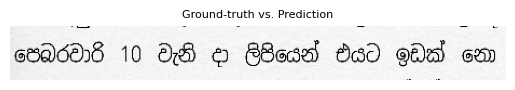

In [17]:
# ⬛⬛⬛  QUICK INFERENCE CELL (no training code)  ⬛⬛⬛
import json, random, regex, torch
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# ─── 1.  PATHS (edit as needed) ───────────────────────────────────────
CROP_DIR  = Path(r"D:\python\data\line_crops")      # contains crops + chars.txt + labels.json
CKPT_PATH = CROP_DIR / "checkpoints" / "crnn_final.pth"
IMG_H, IMG_W = 32, 512                              # must match training

# ─── 2.  CHARSET → stoi / itos ────────────────────────────────────────
with open(CROP_DIR / "chars.txt", encoding="utf-8") as f:
    chars = [ln.rstrip() for ln in f if ln.strip()]
if " " not in chars:                                # safety check
    chars.append(" ")
stoi = {c: i + 1 for i, c in enumerate(chars)}      # 0 = blank
itos = {i: c for c, i in stoi.items()}

# ─── 3.  IMAGE TRANSFORM (same as training) ───────────────────────────
transform = T.Compose([
    T.Resize((IMG_H, IMG_W)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

# ─── 4.  CRNN ARCH (identical to training) ────────────────────────────
class CRNN(nn.Module):
    def __init__(self, n_chars):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        base.conv1.stride = (1, 1)
        base.maxpool = nn.Identity()
        for layer in [base.layer2, base.layer3, base.layer4]:
            for m in layer:
                if hasattr(m, "conv1") and m.conv1.stride == (2, 2):
                    m.conv1.stride = (2, 1)
                    if m.downsample:
                        m.downsample[0].stride = (2, 1)
        self.encoder = nn.Sequential(*list(base.children())[:-2])  # [B,512,H',W']
        feat_h = IMG_H // 8
        self.rnn = nn.LSTM(
            input_size=512 * feat_h,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
        )
        self.classifier = nn.Linear(512, n_chars + 1)  # + blank

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)              # gray → 3-chan
        feat = self.encoder(x)                # [B,512,H',W']
        B, C, H, W = feat.shape
        seq = feat.permute(0, 3, 1, 2).contiguous().view(B, W, C*H)
        rnn_out, _ = self.rnn(seq)            # [B,W,512]
        logits = self.classifier(rnn_out).log_softmax(-1)  # [B,W,n+1]
        return logits.permute(1, 0, 2)        # [T,B,C]

# ─── 5.  LOAD MODEL ──────────────────────────────────────────────────
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(len(stoi)).to(DEVICE)
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
model.eval()
print("✅ Loaded checkpoint:", CKPT_PATH)

# ─── 6.  PICK ONE RANDOM CROP & GROUND TRUTH ─────────────────────────
with open(CROP_DIR / "labels.json", encoding="utf-8") as f:
    label_map = json.load(f)

img_name = random.choice(list(label_map.keys()))
gt_text  = label_map[img_name]

img = Image.open(CROP_DIR / img_name).convert("L")
inp = transform(img).unsqueeze(0).to(DEVICE)        # [1,1,H,W]

# ─── 7.  INFERENCE + GREEDY DECODE ───────────────────────────────────
with torch.no_grad():
    logits = model(inp)                 # [T,1,C]
    pred = logits.argmax(-1).squeeze(1).cpu().numpy()  # [T]
print("Predicted indices:", pred)

decoded = []
prev = -1
for p in pred:                          # collapse repeats & drop blanks
    if p != prev and p != 0:
        decoded.append(itos[p])
    prev = p
pred_text = "".join(decoded)

# ─── 8.  DISPLAY RESULT ─────────────────────────────────────────────
print("\n🖼  Image :", img_name)
print("GT :", gt_text)
print("PRD:", pred_text)

plt.imshow(np.array(img), cmap="gray")
plt.title("Ground-truth vs. Prediction", fontsize=8)
plt.axis("off")
plt.show()
